In [1]:
# import dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts 
from scipy.stats import linregress
import json
import requests

In [2]:
# Load data 
confirmed_xl = 'Resources/tx_confirmed.xlsx'
fatalities_xl = 'Resources/tx_fatalities.xlsx'
county_popn_csv = 'Resources/Population Estimates by County.csv'
county_race_csv = 'Resources/Death_Counts_by_County_and_Race.csv'
tx_census_xl = 'Resources/tx_census.xlsx'
tx_popn_density_csv = 'Resources/avg_household_size_popn_density.csv'
tx_insurance_csv = 'Resources/Health_Insurance_Coverage_-_Counties.csv'

# APIs - documentation in resources folder
tx_65_url = 'https://data.texas.gov/resource/qjby-4sji.json?'

# Save in dataframe 
confirmed_tx = pd.read_excel(confirmed_xl)
fatalities_tx = pd.read_excel(fatalities_xl)
county_popn = pd.read_csv(county_popn_csv)
county_race = pd.read_csv(county_race_csv)
tx_census = pd.read_excel(tx_census_xl)
tx_popn_density = pd.read_csv(tx_popn_density_csv)
tx_insurance = pd.read_csv(tx_insurance_csv)

#### Summary Table: Cases, Fatalities, and Fatality Rate by County

In [3]:
# Drop null rows 
confirmed_tx = confirmed_tx.drop([254, 255])

# Clean up: Delete last row (avoid totaling the total count) / null values & running total columns
fatalities_tx = fatalities_tx[['County Name','Fatalities 02-02-2021']].drop([254,255])

# Get total for each county 
confirmed_tx['Total Confirmed'] = confirmed_tx.sum(axis=1)

# Select only county and total columns 
confirmed_tx = confirmed_tx[['County', 'Total Confirmed']]

# Save copies as new dataframes (avoids deprecation warning)
confirmed_tx = pd.DataFrame(confirmed_tx) 
fatalities_tx = pd.DataFrame(fatalities_tx) 

# Reformat to match columns (Uppercase and lowercase columns converted to titlecase)
confirmed_tx['County'] = confirmed_tx['County'].str.title()
fatalities_tx['County Name'] = fatalities_tx['County Name'].str.title()
fatalities_tx = fatalities_tx.rename(columns={'County Name': 'County'})

# Merge dataframes
summary_cases = pd.merge(confirmed_tx, fatalities_tx, on='County')
summary_cases.head()

## Summary table: add death rate and proportion 65+

# Calculate death rate 
total_cases = summary_cases['Total Confirmed']
total_fatalities = summary_cases['Fatalities 02-02-2021']
summary_cases['% Fatal'] = total_fatalities / total_cases * 100
    
# Add empty column 
summary_cases['% 65+'] =''

# Fix county names (API is case sensitive)
summary_cases = summary_cases.replace({'Mcculloch': 'McCulloch',
                                       'Mclennan': 'McLennan',
                                       'Mcmullen': 'McMullen'})

In [4]:
# Loop through dataframe and use county name to call API
for i, row in summary_cases.iterrows():
    
    county = row[0]
    
    # Use county name to generate query url 
    query_url = tx_65_url + 'county=' + county
    response = requests.get(query_url).json()
    
    # Get percentage of 65+ for each couunty
    try: 
        over_65 = response[0]['_65_and_older_of_population']
        summary_cases.loc[i, '% 65+'] = over_65
    
    # Exception handling in case there is no data for a county 
    except (KeyError, IndexError):
        print(f'Missing information for {county}')
        pass

summary_cases.head()

County  Total Confirmed  Fatalities 02-02-2021   % Fatal  % 65+
0  Anderson           4766.0                     91  1.909358  15.00
1   Andrews           1655.0                     44  2.658610   10.0
2  Angelina           4398.0                    225  5.115962  16.00
3   Aransas            637.0                     31  4.866562  28.00
4    Archer            536.0                     11  2.052239  21.00

## County Fatality Rate Compared to Proportion of Older (65+) Population

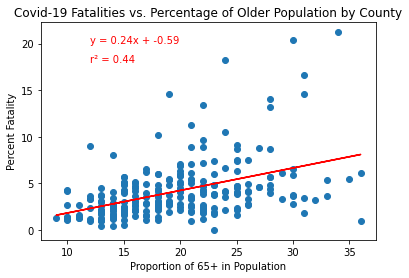

In [5]:
## Build scatterplot

# Drop NaN values 
summary_cases = summary_cases.dropna()

# Get x and y values
x_pc_65 = summary_cases['% 65+']
y_pc_fatality = summary_cases['% Fatal']

# Convert to numeric 
x_pc_65 = pd.to_numeric(x_pc_65)
y_pc_fatality = pd.to_numeric(y_pc_fatality)

# Add to scatterplot
plt.scatter(x_pc_65, y_pc_fatality)

# Labels 
plt.title('Covid-19 Fatalities vs. Percentage of Older Population by County')
plt.xlabel('Proportion of 65+ in Population')
plt.ylabel('Percent Fatality')

# R-squared 
r_sq = sts.pearsonr(x_pc_65, y_pc_fatality)
r_sq = r_sq[0].round(2)
r_value = f"r² = {r_sq}"
plt.annotate(r_value, (12,18), fontsize=10, color='r')

# Add linear regression 
(slope, intercept, r_value, p_value, std_err) = sts.linregress(x_pc_65, y_pc_fatality)
eq = 'y = ' + str(slope.round(2)) + 'x + ' + str((intercept.round(2)))
regression = x_pc_65 * slope + intercept
plt.plot(x_pc_65, regression, 'r')
plt.annotate(eq, (12,20), fontsize=10, color='r')

# Save figure 
plt.savefig('./output_data/fatalities_by_age.png', format='png')

plt.show()

## Fatality Rate Broken Down by Race

#### General Population (TX): Race Distribution

In [6]:
# Get number of each race in Texas 
tx_census_total = tx_census.iloc[2,3]
tx_census_white = tx_census.iloc[4,3]
tx_census_black = tx_census.iloc[5,3]
tx_census_asian = tx_census.iloc[7,3]
tx_census_native = tx_census.iloc[6,3]
tx_census_hispanic = tx_census.iloc[13,3]

# Convert to percentage
tx_pc_white = tx_census_white / tx_census_total * 100
tx_pc_black = tx_census_black / tx_census_total * 100
tx_pc_asian = tx_census_asian / tx_census_total * 100
tx_pc_native = tx_census_native / tx_census_total * 100
tx_pc_hispanic = tx_census_hispanic / tx_census_total * 100

# Save as a list 
tx_census_pc = [tx_pc_white, tx_pc_black, tx_pc_asian, tx_pc_native, tx_pc_hispanic]

#### Texas: Covid-19 Deaths by Race

In [7]:
## Deaths by race/ethnicity 

# Select only rows for TX and Covid-19 deaths 
county_race_tx = county_race.loc[county_race['State'] == 'TX']
county_race_tx = county_race_tx.loc[county_race_tx['Indicator'] == 'Distribution of COVID-19 deaths (%)']

# Clean up - select rows for each race 
county_race_tx = county_race_tx[['County Name', 'COVID-19 Deaths', 
                                 'Non-Hispanic White', 'Non-Hispanic Black' , 
                                 'Non-Hispanic Asian', 'Non-Hispanic American Indian or Alaska Native', 
                                 'Non-Hispanic Native Hawaiian or Other Pacific Islander', 'Hispanic']]

# Create empty dataframe for summary
num_deaths_race = pd.DataFrame(columns = ['County', 'White', 'Black', 'Asian', 'Native', 'Hispanic'])

In [8]:
# Loop through rows and get percentage of deaths by county and race, convert to number  
for index, row in county_race_tx.iterrows():
    
    try: 
        county_name = row[0]
        county_deaths = row[1]
        pc_white = row[2]
        pc_black = row[3]
        pc_asian = row[4]
        pc_native = row[5]
        pc_hispanic = row[7]
        
        # Calculate total number of deaths by race 
        num_white = pc_white * county_deaths
        num_black = pc_black * county_deaths 
        num_asian = pc_asian * county_deaths
        num_native = pc_native * county_deaths
        num_hispanic = pc_hispanic * county_deaths
        
        # Add totals to dataframe 
        num_deaths_race.loc[index, 'County'] = county_name
        num_deaths_race.loc[index, 'White'] = num_white
        num_deaths_race.loc[index, 'Black'] = num_black
        num_deaths_race.loc[index, 'Asian'] = num_asian
        num_deaths_race.loc[index, 'Native'] = num_native 
        num_deaths_race.loc[index, 'Hispanic'] = num_hispanic 
    
    except (KeyError, IndexError):
        pass

# Sum up deaths 
total_white = num_deaths_race['White'].sum(axis=0)
total_black = num_deaths_race['Black'].sum(axis=0)
total_asian = num_deaths_race['Asian'].sum(axis=0)
total_native = num_deaths_race['Native'].sum(axis=0)
total_hispanic = num_deaths_race['Hispanic'].sum(axis=0)

# Total df 
total_df = pd.DataFrame({'County': 'Total',
                       'White': total_white,
                       'Black': total_black,
                       'Asian': total_asian,
                       'Native': total_native, 
                       'Hispanic': total_hispanic}, index=[0])

# Append to dataframe
num_deaths_race_total = num_deaths_race.append(total_df)

num_deaths_race_total.tail()

County    White    Black    Asian  Native Hispanic
1786        Webb County   10.234      NaN      NaN     NaN   589.96
1789     Wichita County  281.152   26.128      NaN     NaN   58.144
1792  Williamson County   287.02   26.216      NaN     NaN  127.916
1795        Wise County   95.004      NaN      NaN     NaN   19.952
0                 Total  13729.4  3522.26  661.836  11.925    17085

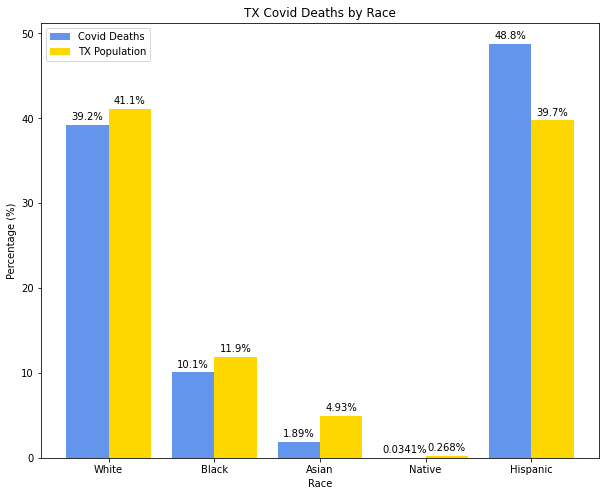

In [9]:
# Bar chart of deaths by race (compare to bar chart of TX race distribution) and run test

# Combined percentage of deaths
est_total = total_white + total_black + total_asian + total_native + total_hispanic
total_pc_white = total_white / est_total * 100
total_pc_black = total_black / est_total * 100
total_pc_asian = total_asian / est_total * 100 
total_pc_native = total_native / est_total * 100 
total_pc_hispanic = total_hispanic / est_total * 100

# Get bar chart heights
x_bar = [total_pc_white, total_pc_black, total_pc_asian, total_pc_native, total_pc_hispanic]
x_popn = tx_census_pc

# X ticks 
x_labels = ['White', 'Black', 'Asian', 'Native', 'Hispanic']
x_axis = np.arange(len(x_labels))

# Bar chart 
fig, ax = plt.subplots(figsize=(10,8))
plt.xticks(x_axis, x_labels)
width = 0.4

# Add heights 
deaths_by_race = ax.bar(x_axis - width/2 , x_bar, 
                        width, color='cornflowerblue', 
                        label='Covid Deaths')
tx_race_demographics = ax.bar(x_axis + width/2, x_popn, 
                              width, color='gold', 
                              label='TX Population')

# Add labels and title 
plt.ylabel('Percentage (%)')
plt.xlabel('Race')
plt.title('TX Covid Deaths by Race')
plt.legend()

# Add percentages
def add_labels(barchart):
    for bars in barchart:
        height = bars.get_height()
        ax.annotate('{:.3}%'.format(height),
                    xy=(bars.get_x() + bars.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')
add_labels(deaths_by_race)
add_labels(tx_race_demographics)

# Save figure
plt.savefig('./output_data/covid_deaths_by_race.png', format='png')

plt.show()

### Analysis

In [10]:
## Get critical value 
critical_value = sts.chi2.ppf(q= 0.95, df=4)
critical_value

# Get observed values
observed = total_df[['White', 'Black', 'Asian', 'Native', 'Hispanic']].transpose()

# Calculate expected values (% of TX population * Total number deaths)
expected_w = (tx_pc_white / 100) * est_total
expected_b = (tx_pc_black / 100) * est_total
expected_a = (tx_pc_asian / 100) * est_total
expected_n = (tx_pc_native / 100) * est_total
expected_h = (tx_pc_hispanic / 100) * est_total

expected_values = [expected_w, expected_b, expected_a, expected_n, expected_h]
expected = pd.DataFrame(expected_values)

# Chi-squared test for statistical significance
chi_sq = sts.chisquare(observed[0], f_exp=expected[0])
chi_sq

print(f'The critical value is {critical_value} and the Chi-Squared value is {chi_sq}')

The critical value is 9.487729036781154 and the Chi-Squared value is Power_divergenceResult(statistic=1578.904532207257, pvalue=0.0)


## Infections and Population Density


In [11]:
# Clean up dataset 
popn_density_df = tx_popn_density[['NAME', 'B01001_calc_PopDensity']]
popn_density_df = popn_density_df.rename(columns={'NAME': 'County','B01001_calc_PopDensity': 'Popn Density (people per km2)'})

# Rename columns
county_popn.rename(columns={'Population Estimates by County': 'County', 'Unnamed: 1': 'Population'})
county_popn.head()

# Strip ('County') and merge with infections/fatality dataframe
popn_density_df['County'] = popn_density_df['County'].str.replace(' County', '')

# Merge county populations with county summary frame, select relevant columns
density_infections_1_df = pd.merge(popn_density_df, summary_cases, on='County')
density_infections_1_df = density_infections_1_df[['County', 'Popn Density (people per km2)', 'Total Confirmed']]

# Strip 'County' to merge with previous dataframe
county_popn['County'] = county_popn['Population Estimates by County'].str.replace(' County', '')

# Remove comma from numbers
county_popn['Unnamed: 1'] = county_popn['Unnamed: 1'].str.replace(',', '')

# Rename columns 
county_popn = county_popn.rename(columns={'Unnamed: 1': 'Total Population'})

# Merge population data with density and infection data 
density_infections_df = pd.merge(county_popn, density_infections_1_df, 
                                 on='County', how='right')
density_infections_df = density_infections_df.drop(columns = ['Population Estimates by County'])

# Convert columns to numeric 
county_Population = pd.to_numeric(density_infections_df['Total Population'])
county_confirmed = pd.to_numeric(density_infections_df['Total Confirmed'])

# Calculate percent infected
density_infections_df['% Infected'] = county_confirmed / county_Population * 100
density_infections_df = density_infections_df.dropna()

density_infections_df.head()

Total Population    County  Popn Density (people per km2)  Total Confirmed  \
0            57735  Anderson                      21.024280           4766.0   
1            18705   Andrews                       4.584175           1655.0   
2            86715  Angelina                      42.399121           4398.0   
3            23510   Aransas                      37.933248            637.0   
4             8553    Archer                       3.756773            536.0   

   % Infected  
0    8.254958  
1    8.847902  
2    5.071787  
3    2.709485  
4    6.266807

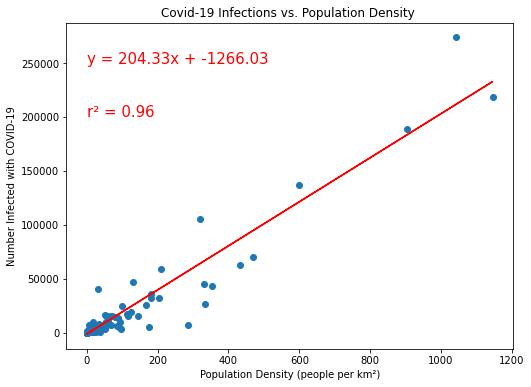

In [12]:
# Get x and y values
x_density = density_infections_df['Popn Density (people per km2)']
y_infection = density_infections_df['Total Confirmed']

# Convert to numeric 
x_density = pd.to_numeric(x_density)
y_infection = pd.to_numeric(y_infection)

# Add to scatterplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x_density, y_infection)

# Labels 
plt.title('Covid-19 Infections vs. Population Density ')
plt.xlabel('Population Density (people per km²)')
plt.ylabel('Number Infected with COVID-19')

# R-squared 
r_sq = sts.pearsonr(x_density, y_infection)
r_sq = r_sq[0].round(2)
r_value = f"r² = {r_sq}"
plt.annotate(r_value, (0, 200000), fontsize=15, color='r')

# Add linear regression 
(slope, intercept, r_value, p_value, std_err) = sts.linregress(x_density, y_infection)
eq = 'y = ' + str(slope.round(2)) + 'x + ' + str((intercept.round(2)))
regression = x_density * slope + intercept
plt.plot(x_density, regression, 'r')
plt.annotate(eq, (0, 250000), fontsize=15, color='r')



# Save figure 
plt.savefig('./output_data/infections_by_density.png', format='png')

plt.show()

## Health Insurance Coverage

In [13]:
# Clean up - select county and population without health insurance
tx_insurance_df = tx_insurance[['GEO_NAME', 'DP03_0099PE']]
tx_insurance_df = tx_insurance_df.rename(columns={'GEO_NAME': 'County',
                                                 'DP03_0099PE': '% of Popn W/out Health Insurance'})
# Strip the word 'County' to merge with existing dataframe
tx_insurance_df['County'] = tx_insurance_df['County'].str.replace(' County', '')

# Merge with summary dataframes, select columns 
insurance_infections_df = pd.merge(tx_insurance_df, summary_cases, on='County')
insurance_infections_df = insurance_infections_df[['County', '% of Popn W/out Health Insurance', 
                                                   '% Fatal']]
insurance_infections_df

County  % of Popn W/out Health Insurance   % Fatal
0    Anderson                              14.1  1.909358
1     Andrews                              18.2  2.658610
2    Angelina                              19.2  5.115962
3     Aransas                              20.5  4.866562
4      Archer                              11.4  2.052239
..        ...                               ...       ...
247    Yoakum                              22.4  2.944641
248     Young                              18.6  2.373316
249    Zapata                              29.3  1.713860
250    Zavala                              18.4  2.352941
251      King                               7.9  0.000000

[252 rows x 3 columns]

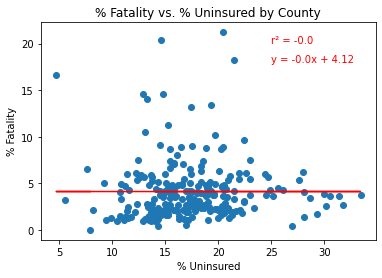

In [14]:
# Scatterplot
# Get x and y columns 
x_insurance = insurance_infections_df['% of Popn W/out Health Insurance']
y_fatality = insurance_infections_df['% Fatal']

# Convert to numeric 
x_insurance = pd.to_numeric(x_insurance)
y_fatality = pd.to_numeric(y_fatality)

# Add to scatterplot 
fig, ax = plt.subplots()
ax.scatter(x_insurance, y_fatality)

plt.title('% Fatality vs. % Uninsured by County')
plt.xlabel('% Uninsured')
plt.ylabel('% Fatality')

## Linear Regression and Correlation Coefficient 
# R-squared 
r_sq = sts.pearsonr(x_insurance, y_fatality)
r_sq = r_sq[0].round(2)
r_value = f"r² = {r_sq}"
plt.annotate(r_value, (25,20), fontsize=10, color='r')

# Add linear regression 
(slope, intercept, r_value, p_value, std_err) = sts.linregress(x_insurance, y_fatality)
eq = 'y = ' + str(slope.round(2)) + 'x + ' + str((intercept.round(2)))
regression = x_insurance * slope + intercept
plt.plot(x_insurance, regression, 'r')
plt.annotate(eq, (25,18), fontsize=10, color='r')

plt.show()